In [1]:
import numpy as np
import matplotlib.pyplot as plt
from profit.sur.backend.gp_functions import invert, nll
from profit.sur.backend.kernels import kern_sqexp
from profit.util.halton import halton

In [2]:
def f(x): return x*np.cos(10*x)

# Custom function to build GP matrix
def build_K(xa, xb, hyp, K):
    for i in np.arange(len(xa)):
        for j in np.arange(len(xb)):
            K[i, j] = kern_sqexp(xa[i], xb[j], hyp[0])

noise_train = 0.01

ntrain = 20
xtrain = halton(1, ntrain)
ftrain = f(xtrain)
np.random.seed(0)
ytrain = ftrain + noise_train*np.random.randn(ntrain, 1)

In [3]:
# GP regression with fixed kernel hyperparameters
hyp = [0.5, 1e-6]  # l and sig_noise**2

K = np.empty((ntrain, ntrain))   # train-train
build_K(xtrain, xtrain, hyp, K)  # writes inside K
Ky = K + hyp[-1]*np.eye(ntrain)
Kyinv = invert(Ky, 4, 1e-6)       # using gp_functions.invert

ntest = 30
xtest = np.linspace(0, 1, ntest)
ftest = f(xtest)

Ks = np.empty((ntrain, ntest))  # train-test
Kss = np.empty((ntest, ntest))  # test-test
build_K(xtrain, xtest, hyp, Ks)
build_K(xtest, xtest, hyp, Kss)

fmean = Ks.T.dot(Kyinv.dot(ytrain)) # predictive mean
 

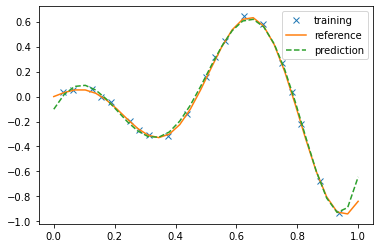

In [4]:
plt.figure()
plt.plot(xtrain, ytrain, 'x')
plt.plot(xtest, ftest, '-')
plt.plot(xtest, fmean, '--')
plt.legend(('training', 'reference', 'prediction'))

In [5]:
# Negative log likelihood over length scale
ls = np.linspace(1e-3, 3, 50)
nlls = np.array(
    [nll([l, 0.00694534], xtrain, ytrain, 0) for l in ls]
    ).flatten()

Text(0.5, 1.0, 'Negative log-likelihood')

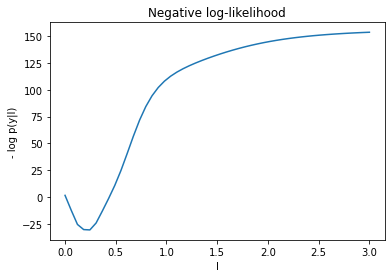

In [6]:
plt.figure()
plt.plot(ls, nlls)
plt.xlabel('l')
plt.ylabel('- log p(y|l)')
plt.title('Negative log-likelihood')

In [7]:
from scipy.optimize import minimize

def nll_transform(log10hyp):
    hyp = 10**log10hyp
    return nll(hyp, xtrain, ytrain, 0)

res = minimize(nll_transform, np.array([0, -6]), method='BFGS')

In [8]:
print(res)
print('[l,sig2] = ', 10**res.x)

      fun: -51.354273790302386
 hess_inv: array([[0.0013394 , 0.00029531],
       [0.00029531, 0.02986399]])
      jac: array([1.38282776e-05, 2.40325928e-04])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 464
      nit: 23
     njev: 113
   status: 2
  success: False
        x: array([-0.64803442, -4.02324497])
[l,sig2] =  [2.24887634e-01 9.47883646e-05]


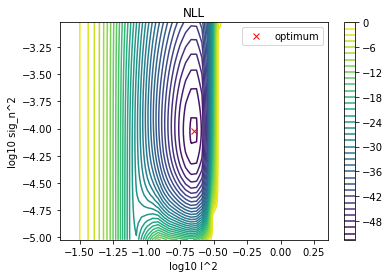

In [9]:
nl = 50
ns2 = 40

log10l = np.linspace(res.x[0]-1, res.x[0]+1, nl)
log10s2 = np.linspace(res.x[1]-1, res.x[1]+1, ns2)
[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nll([10**ll, 10**ls2], xtrain, ytrain, 0) for ls2 in log10s2 for ll in log10l]
    ).reshape([ns2, nl])

# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL')
plt.contour(Ll, Ls2, nlls, levels=50)
plt.plot(res.x[0], res.x[1], 'rx')
plt.xlabel('log10 l^2')
plt.ylabel('log10 sig_n^2')
plt.colorbar()
plt.legend(['optimum'])
plt.show()

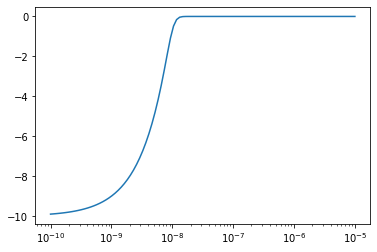

In [21]:
# Trying out priors to cut values

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def prior(hyp):
    return sigmoid(hyp[0]-6)*sigmoid(hyp[-1]-6)

x = np.logspace(-10, -5, 100)
plt.semilogx(x, np.log(sigmoid(1e9*x - 10)))